In [1]:
# This code below is to se the structure of the code for Pyramidal Neuron - Larkum style
# Learning through target spikes

import numpy as np

from lttb import LTTB

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 5, 3, 400
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 20.
sigma_targ = 5.#10**1.5#
sigma_in = 12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = 2

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout, 'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 10

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb = LTTB (par)


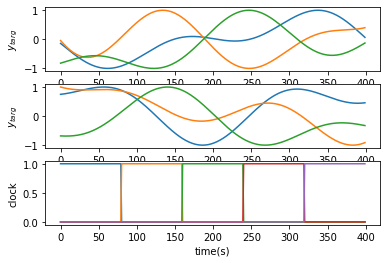

In [2]:
# define clock and target

lttb.init_targ(par)
lttb.y_targ_1 = lttb.y_targ

lttb.init_targ(par)
lttb.y_targ_2 = lttb.y_targ

lttb.init_clock(par)


plt.figure()
plt.subplot(311)
plt.plot(np.array(lttb.y_targ_1).T)
plt.ylabel('$y_{targ}$')
plt.subplot(312)
plt.plot(np.array(lttb.y_targ_2).T)
plt.ylabel('$y_{targ}$')
plt.subplot(313)
plt.plot(np.array(lttb.I_clock).T)
plt.xlabel('time(s)')
plt.ylabel('clock')
plt.show()


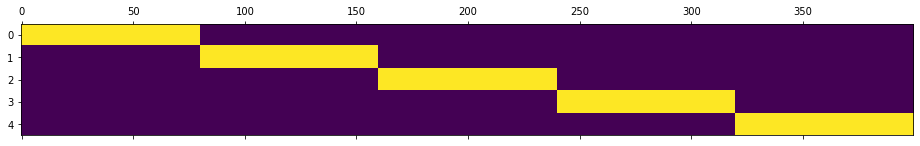

In [3]:
plt.matshow(lttb.I_clock,aspect='auto')

MATLAB code to be converted below

In [4]:
## Training Rec

gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 500

eta = 5.
eta_out = 0.1
etaW = .0


for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(2):
    
        lttb.cont = lttb.cont*0
        lttb.cont[cont_index] = 1
        if cont_index ==0:
            lttb.y_targ = lttb.y_targ_1
        else:
            lttb.y_targ = lttb.y_targ_2
    

        lttb.initialize(par)

        #run simulation
        dH = 0

        for t in range(lttb.T-2):
            
            lttb.step(apicalFactor = apicalFactorTrain)

            dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]

            DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_dist[:,t]) ,dH)
            lttb.J =  lttb.J + eta*DJ

            SR = lttb.S_filtRO[:,t+1]#lttb.B_filt_rec[:,t+1]#
            Y = lttb.Jout@SR
            DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
            lttb.Jout =  lttb.Jout + eta_out*DJRO
        
    ###### Test
    
    if iter%50==0:

        for cont_index in range(2):

            lttb.cont = lttb.cont*0
            lttb.cont[cont_index] = 1
            
            if cont_index ==0:
                lttb.y_targ = lttb.y_targ_1
            else:
                lttb.y_targ = lttb.y_targ_2

            lttb.initialize(par)

            #run simulation

            for t in range(lttb.T-2):
                
                lttb.step(apicalFactor = apicalFactorTest)

            SR = lttb.S_filtRO[:,1:-2]# lttb.B_filt_rec[:,1:-2]#
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

            print(mse_rec_train)
            

0.621391476394514
0.3955373587514118
0.08866060165205222
0.0616128855550814
0.08084503441347968
0.0661039799387916
0.08214416954710205
0.05223715026136895
0.060416388973695334
0.05360285929847921
0.08934901679657757
0.04487904722269543
0.06575713270167331
0.055615947551347515
0.08158280667691635
0.03699411216147559
0.07553332757988951
0.05995897671545774
0.0967923313509363
0.051687607953388524


In [5]:
#np.shape(lttb.j_cont@lttb.cont)
t = 1
apicalFactor = 1
#lttb.Vapic[:,t] = lttb.Vapic[:,t-1]*(1-lttb.dt/lttb.tau_m) + lttb.dt/lttb.tau_m*(lttb.j_targ@lttb.y_targ[:,t]*apicalFactor +
#lttb.j_cont@lttb.cont + lttb.h + lttb.href)# + lttb.VresetApic*lttb.S_apic_dist[:,t]
np.shape(lttb.Vapic[:,t-1]*(1-lttb.dt/lttb.tau_m) + lttb.dt/lttb.tau_m*(lttb.j_targ@lttb.y_targ[:,t]*apicalFactor + (lttb.j_cont@lttb.cont) + lttb.h + lttb.href))

(500,)

In [6]:
lttb.t

398

0.10489528495634966


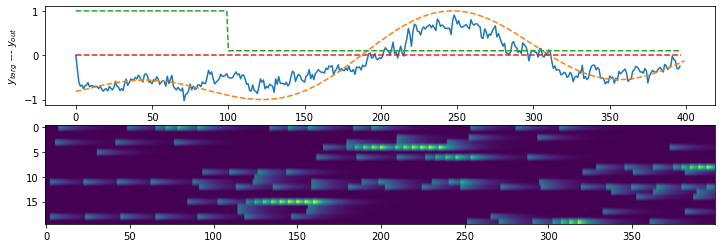

0.11557393197441067


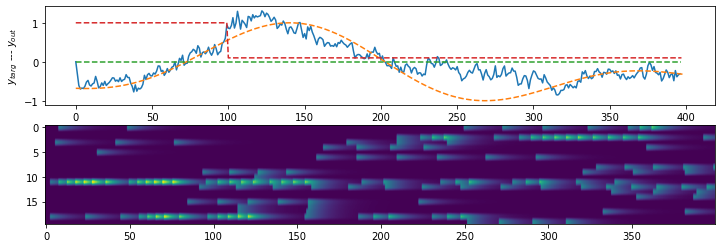

In [17]:
for cont_index in range(2):
    
    context = []

    lttb.cont = lttb.cont*0
    lttb.cont[cont_index] = 1

    if cont_index ==0:
        lttb.y_targ = lttb.y_targ_1
    else:
        lttb.y_targ = lttb.y_targ_2

    lttb.initialize(par)

    #run simulation
    
    apicalFactor = 0

    for t in range(lttb.T-2):
 
        if t==100:
            apicalFactor = 0
            lttb.cont = lttb.cont*0.1
            #lttb.cont[0] = 1
        context.append(lttb.cont)
          
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.S_filtRO[:,1:-2]#lttb.B_filt_rec[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y[2,:].T)
    plt.plot(lttb.y_targ[2,:].T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.S_filtRO[0:20,:],aspect='auto')
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

0.1120575369860385


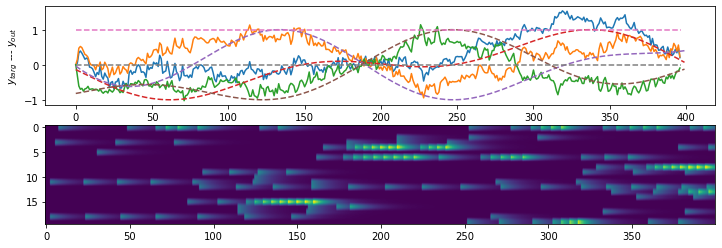

0.6694483277425545


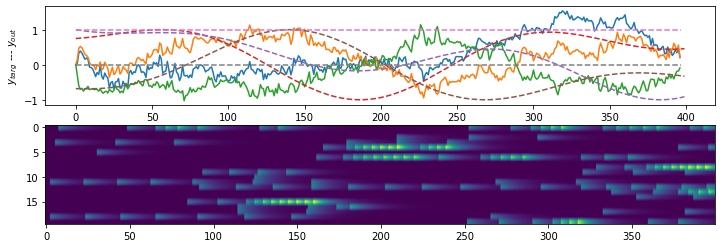

0.846925544427178


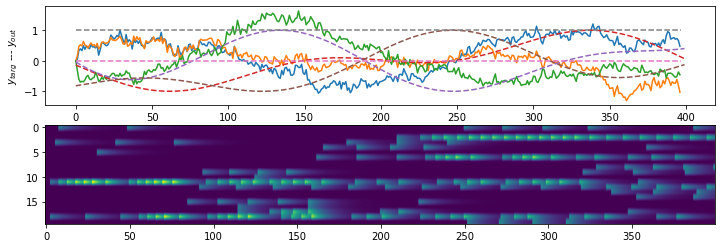

0.0739890202760611


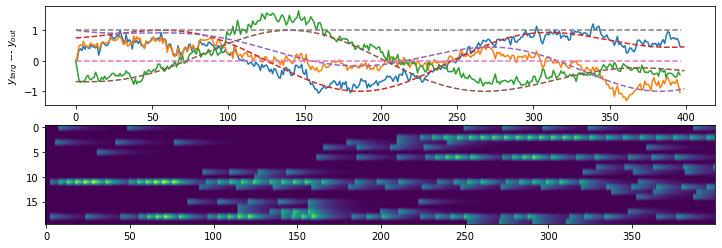

In [11]:
MSE = np.zeros((2,2))

for cont_index_i in range(2):
    for cont_index in range(2):

        context = []

        lttb.cont = lttb.cont*0
        lttb.cont[cont_index_i] = 1

        if cont_index ==0:
            lttb.y_targ = lttb.y_targ_1
        else:
            lttb.y_targ = lttb.y_targ_2

        lttb.initialize(par)

        #run simulation

        apicalFactor = 0

        for t in range(lttb.T-2):

            #if t==200:
                #apicalFactor = 0
                #lttb.cont = lttb.cont*0.1
                #lttb.cont[0] = 1
            context.append(lttb.cont)

            lttb.step(apicalFactor = apicalFactor)

        SR = lttb.S_filtRO[:,1:-2]#lttb.B_filt_rec[:,1:-2]#
        Y = lttb.Jout@SR
        mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

        print(mse_rec_train)
        MSE[cont_index_i,cont_index] = mse_rec_train

    #mse, Y = lttb.train_ro(par,out_epochs = 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(211)
        plt.plot(Y.T)
        plt.plot(lttb.y_targ.T,'--')
        plt.plot(np.array(context),'--')

        plt.xlabel('time(s)')
        plt.ylabel('$y_{targ}$ --- $y_{out}$')
        plt.subplot(212)
        plt.imshow(lttb.S_filtRO[0:20,:],aspect='auto')

        #plt.subplot(313)
        #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')

        plt.show()

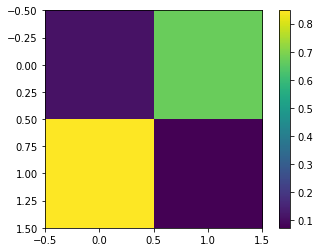

In [12]:
plt.imshow(MSE)
plt.colorbar()